In [1]:
#%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Loading in data and selecting relevant columns

In [3]:
df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')
# Based on the guidance, let's start preprocessing by filtering the dataset based on quality scores.

relevant_columns = [
    'cdr3.alpha', 'v.alpha', 'j.alpha',
    'species', 'mhc.a',  'antigen.gene','antigen.epitope', 'vdjdb.score'
]

# For the purpose of this example, we won't filter out lower-quality scores to avoid data imbalance,
# but in practice, you may want to consider this based on the dataset's size and distribution.
filtered_data = df[relevant_columns]
# Displaying the first few rows of the filtered dataset to verify the selection
filtered_data


C:\Users\vikra\AppData\Local\Temp\ipykernel_7136\3038122650.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')


,cdr3.alpha,v.alpha,j.alpha,species,mhc.a,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
1,NaN,NaN,NaN,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
3,CAVKASGSRLT,TRAV2*01,NaN,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
...,...,...,...,...,...,...,...,...
62172,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQPELPYPQPQL,0
62173,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQPELPYPQPQL,0
62174,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQQPFPQPEQPFP,0
62175,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQQPFPQPEQPFP,2


# examining missing and unique values

In [4]:
# Checking for missing values in crucial columns
missing_values = filtered_data.isnull().sum()

# Examining the number of unique values in categorical columns for potential encoding strategies
unique_values = filtered_data.nunique()

# Preparing the report
report = {
    "Missing Values": missing_values,
    "Unique Values": unique_values
}

report


{'Missing Values': cdr3.alpha         24128
 v.alpha            24204
 j.alpha            25157
 species                0
 mhc.a                  0
 antigen.gene          31
 antigen.epitope        0
 vdjdb.score            0
 dtype: int64,
 'Unique Values': cdr3.alpha         27097
 v.alpha              158
 j.alpha               65
 species                3
 mhc.a                119
 antigen.gene         268
 antigen.epitope     1169
 vdjdb.score            4
 dtype: int64}

In [6]:
# Removing rows with missing cdr3 sequences
df_cleaned = filtered_data.dropna(subset=['cdr3.alpha'])
#df_cleaned = filtered_data.copy()
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned


,cdr3.alpha,v.alpha,j.alpha,species,mhc.a,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
2,CAVKASGSRLT,TRAV2*01,NaN,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,Nef,FLKEQGGL,2
...,...,...,...,...,...,...,...,...
38044,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQPELPYPQPQL,0
38045,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQPELPYPQPQL,0
38046,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQQPFPQPEQPFP,0
38047,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQQPFPQPEQPFP,2


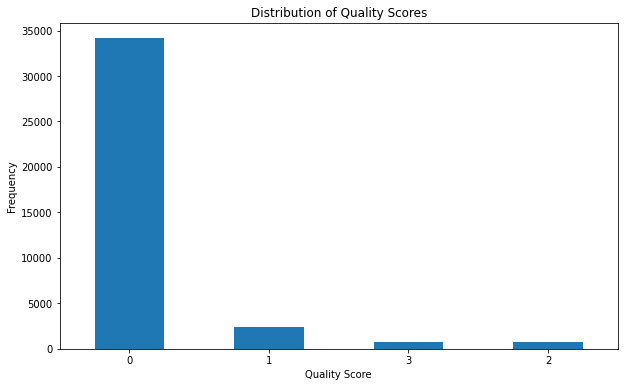

0    34159
1     2405
3      749
2      736
Name: vdjdb.score, dtype: int64

In [7]:
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is your cleaned DataFrame after removing rows with missing cdr3 sequences
quality_scores = df_cleaned['vdjdb.score'].value_counts()

# Plotting the distribution of quality scores
plt.figure(figsize=(10, 6))
quality_scores.plot(kind='bar')
plt.title('Distribution of Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for readability
plt.show()
quality_scores

whilst 0 is the most frequent class, the data with a score of 0 can be seen to be unreliable, so it is filtered out.

In [8]:
# Filtering out data points with a quality score of 0
df_filtered = df_cleaned[df_cleaned['vdjdb.score'] > 0]
# Removing the 'd.beta' column from the filtered DataFrame
#df_filtered = df_filtered.drop(columns=['d.beta'])

df_filtered[:]



,cdr3.alpha,v.alpha,j.alpha,species,mhc.a,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
2,CAVKASGSRLT,TRAV2*01,NaN,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,Nef,FLKEQGGL,2
...,...,...,...,...,...,...,...,...
38004,CIALNARLMF,TRAV26-1*01,TRAJ31*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQPELPYPQPQL,2
38005,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,HomoSapiens,HLA-DQA1*05:01,Gluten,FPQPEQPFPWQP,2
38006,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,Gluten,FPQPEQPFPWQP,2
38008,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,HomoSapiens,HLA-DQA1*05:01,Gluten,QLQPFPQPELPY,2


In [9]:
df_slim = df_filtered.copy()

df_slim.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)

df_slim.to_csv('df_slim.csv', index = False)
df_slim

,cdr3_a_aa,v_a_gene,j_a_gene,species,mhc.a,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
2,CAVKASGSRLT,TRAV2*01,NaN,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,HomoSapiens,HLA-B*08,Nef,FLKEKGGL,2
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,Nef,FLKEQGGL,2
...,...,...,...,...,...,...,...,...
38004,CIALNARLMF,TRAV26-1*01,TRAJ31*01,HomoSapiens,HLA-DQA1*05:01,Gluten,PQPELPYPQPQL,2
38005,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,HomoSapiens,HLA-DQA1*05:01,Gluten,FPQPEQPFPWQP,2
38006,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,Gluten,FPQPEQPFPWQP,2
38008,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,HomoSapiens,HLA-DQA1*05:01,Gluten,QLQPFPQPELPY,2


In [10]:
print(df_slim['species'].unique())

['HomoSapiens' 'MusMusculus' 'MacacaMulatta']


In [11]:
df_mouse = df_slim[df_slim['species'] == 'MusMusculus']
df_human = df_slim[df_slim['species']=='HomoSapiens']
print(df_mouse.shape)
print(df_human.shape)

(951, 8)
(2911, 8)


In [13]:
# Filtering rows where species is "Mus" (assuming "Mus" represents mouse)
# It seems from the initial peek that the dataset might not contain "Mus" directly, so let's filter for anything that's not "HomoSapiens"
# to potentially capture the mouse data if labeled differently (e.g., Mus musculus or simply Mus)



# Creating the datasets
# 1. Mouse species data with alpha chains
human_alpha = df_human[['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'species','antigen.gene','antigen.epitope']]

# 2. Mouse species data with beta chains
#human_beta = df_human[['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'species', 'antigen.gene',	'antigen.epitope']]

# 3. Mouse species data with both chains
#human_both = df_human.copy()
# Resetting index for each dataset before saving
human_alpha.reset_index(drop=True, inplace=True)
#human_beta.reset_index(drop=True, inplace=True)
#human_both.reset_index(drop=True, inplace=True)


# Let's check the number of rows in each dataset to ensure we have mouse data
#mouse_alpha.shape[0], mouse_beta.shape[0], mouse_both.shape[0]

# Assuming your DataFrame is named mouse_beta_df and the epitope information is in a column named 'antigen.epitope'

# Count the occurrences of each epitope
#epitope_counts = human_beta['antigen.epitope'].value_counts()

# Filter for epitopes with more than 4 entries
#epitopes_with_more_than_four_entries = epitope_counts[epitope_counts > 4].index

# Filter the original DataFrame
#filtered_human_beta_df = mouse_beta[mouse_beta['antigen.epitope'].isin(epitopes_with_more_than_four_entries)]
#human_beta['antigen.epitope'].value_counts()


In [14]:
human_alpha.dropna(inplace=True)
human_alpha.shape

C:\Users\vikra\AppData\Local\Temp\ipykernel_7136\3073991814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_alpha.dropna(inplace=True)


(2752, 6)

In [15]:
human_alpha.drop_duplicates(inplace=True)

C:\Users\vikra\AppData\Local\Temp\ipykernel_7136\3888452259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_alpha.drop_duplicates(inplace=True)


In [16]:
human_alpha.shape

(1812, 6)

In [21]:
epitope_counts = human_alpha['antigen.epitope'].value_counts()
filtered_epitopes = (epitope_counts[epitope_counts>24]).index.to_list()
print(len(filtered_epitopes))

10


In [23]:
human_alpha = human_alpha[human_alpha['antigen.epitope'].isin(filtered_epitopes)]
human_alpha.head()

,cdr3_a_aa,v_a_gene,j_a_gene,species,antigen.gene,antigen.epitope
64,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,HomoSapiens,M,GILGFVFTL
91,CARNTGNQFYF,TRAV24*01,TRAJ49*01,HomoSapiens,pp65,NLVPMVATV
100,CAEDNNARLMF,TRAV5*01,TRAJ31*01,HomoSapiens,BMLF1,GLCTLVAML
142,CAFITGNQFYF,TRAV24*01,TRAJ49*01,HomoSapiens,pp65,NLVPMVATV
143,CILDNNNDMRF,TRAV26-2*01,TRAJ43*01,HomoSapiens,pp65,NLVPMVATV


In [24]:
human_alpha.shape

(811, 6)

In [25]:
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'
organism = 'human'
db_file = 'alphabeta_gammadelta_db.tsv'

In [27]:
tr = TCRrep(cell_df=human_alpha,
            organism='human',
            chains=['alpha'],
            db_file='alphabeta_gammadelta_db.tsv',
            deduplicate=True)

#tr.show_incomplete()

C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [29]:
X_beta = pd.DataFrame(tr.pw_alpha )
Y_beta = tr.clone_df['antigen.epitope'].copy() # target labels
X_beta.to_csv('X_beta.csv',index = False)
Y_beta.to_csv('Y_beta.csv',index = False)

#clustering

In [30]:
#X_beta = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
X_beta

,0,1,2,3,4,5,6,7,8,9,...,801,802,803,804,805,806,807,808,809,810
0,0,150,90,45,90,120,111,102,131,90,...,144,117,141,135,117,183,112,126,138,131
1,150,0,171,162,132,195,183,194,178,141,...,221,200,182,196,182,196,167,201,212,205
2,90,171,0,45,105,129,119,122,151,96,...,133,121,121,131,130,155,139,128,148,132
3,45,162,45,0,96,120,110,110,133,96,...,145,118,142,131,118,179,115,128,133,132
4,90,132,105,96,0,63,51,110,154,69,...,155,140,143,157,140,184,86,105,164,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,183,196,155,179,184,182,191,199,157,181,...,180,159,150,87,159,0,168,189,182,184
807,112,167,139,115,86,101,99,116,138,122,...,144,129,141,129,132,168,0,170,146,155
808,126,201,128,128,105,122,129,99,158,108,...,167,158,170,153,158,189,170,0,162,111
809,138,212,148,133,164,169,159,140,158,152,...,153,138,150,146,138,182,146,162,0,161


In [31]:
Y_beta = tr.clone_df['antigen.epitope'].copy()
Y_beta

0         GILGFVFTL
1         NLVPMVATV
2         NLVPMVATV
3         NLVPMVATV
4         GLCTLVAML
           ...     
806       QYIKWPWYI
807    DATYQRTRALVR
808       YLQPRTFLL
809       QYIKWPWYI
810       NLVPMVATV
Name: antigen.epitope, Length: 811, dtype: object

In [32]:
df_m = X_beta.copy()
df_m['epitope'] = Y_beta

In [33]:
df_m.head()

,0,1,2,3,4,5,6,7,8,9,...,802,803,804,805,806,807,808,809,810,epitope
0,0,150,90,45,90,120,111,102,131,90,...,117,141,135,117,183,112,126,138,131,GILGFVFTL
1,150,0,171,162,132,195,183,194,178,141,...,200,182,196,182,196,167,201,212,205,NLVPMVATV
2,90,171,0,45,105,129,119,122,151,96,...,121,121,131,130,155,139,128,148,132,NLVPMVATV
3,45,162,45,0,96,120,110,110,133,96,...,118,142,131,118,179,115,128,133,132,NLVPMVATV
4,90,132,105,96,0,63,51,110,154,69,...,140,143,157,140,184,86,105,164,127,GLCTLVAML


In [34]:
df_bgm = df_m.copy()

In [35]:
print(len(df_m['epitope'].unique()))

10


In [36]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_beta)

tsne = TSNE(n_components = 2, random_state= 42)

tsne_result = tsne.fit_transform(X_scaled)

C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [37]:
df_m['tsne_1'] = tsne_result[:,0]
df_m['tsne_2'] = tsne_result[:,1]
df_m = df_m.sort_values('epitope')

In [38]:
df_m.head()

,0,1,2,3,4,5,6,7,8,9,...,804,805,806,807,808,809,810,epitope,tsne_1,tsne_2
552,90,182,104,95,110,127,127,60,156,98,...,151,127,184,116,123,134,116,DATYQRTRALVR,33.509995,0.794373
581,129,199,125,125,127,129,137,138,140,130,...,147,148,159,137,163,136,155,DATYQRTRALVR,4.407722,17.598549
247,119,199,130,121,139,114,146,132,81,112,...,136,130,169,141,143,146,161,DATYQRTRALVR,-20.566874,0.488029
706,152,124,170,146,163,169,169,180,143,163,...,159,163,171,127,197,140,195,DATYQRTRALVR,-11.950898,-29.226246
551,123,203,122,128,110,127,127,81,165,113,...,160,142,181,125,132,161,95,DATYQRTRALVR,29.928799,-3.499990


In [40]:
import seaborn as sns
#sns.set(rc = {'figure.figsize':(10,10)})
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<Figure size 20000x20000 with 0 Axes>

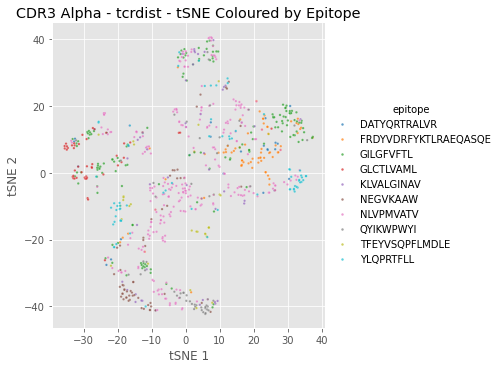

In [41]:

#sns.set(rc = {'figure.figsize':(10,10)})

plt.figure(figsize=(20, 20), dpi = 1000)

#sns.set_style = "whitegrid"



figure = sns.relplot(data=df_m,x=tsne_result[:, 0],y= tsne_result[:, 1], s= 6, alpha= 0.7, hue='epitope', palette = 'tab10', legend = "full")
plt.title('CDR3 Alpha - tcrdist - tSNE Coloured by Epitope')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.savefig('tcrdist_alphaslim1.png', dpi =1000, bbox_inches = 'tight')